<a href="https://colab.research.google.com/github/thunderstorm25/goo_cola/blob/main/IDS_CA2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import pearsonr, ttest_ind
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/dataset/player_stats.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Initial data exploration
print("Dataset shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Analyze missing value patterns before filling
print("\nMissing 'marking' values by position:")
position_missing = df.groupby('att_position')['marking'].apply(lambda x: x.isnull().mean()*100).sort_values(ascending=False)
print(position_missing.head())

# Handle missing values in 'marking' column
positions = df.groupby(['att_position'])['marking'].mean().to_dict()
df['marking'] = df.apply(lambda x: positions.get(x['att_position']) if pd.isna(x['marking']) else x['marking'], axis=1)

# Convert 'value' from object to numeric
df['value'] = df['value'].str.replace(r'[€$]', '', regex=True)
df['value'] = df['value'].str.replace(r'\.', '', regex=True)
df['value'] = df['value'].str.replace('M', '000000', regex=True)
df['value'] = df['value'].str.replace('K', '000', regex=True)
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Fill missing values in 'value' column
if df['value'].isna().sum() > 0:
    position_value_median = df.groupby('att_position')['value'].median()
    df['value'] = df.apply(lambda x: position_value_median.get(x['att_position']) if pd.isna(x['value']) else x['value'], axis=1)
    print("Filled missing values with position median")

# Feature engineering
df['attacking_quotient'] = df[['finishing', 'shot_power', 'long_shots', 'volleys', 'penalties', 'att_position', 'ball_control', 'dribbling']].mean(axis=1)
df['defensive_quotient'] = df[['marking', 'stand_tackle', 'slide_tackle', 'interceptions', 'aggression']].mean(axis=1)
df['technical_ability'] = df[['ball_control', 'dribbling', 'short_pass', 'long_pass']].mean(axis=1)
df['physical_prowess'] = df[['strength', 'stamina', 'sprint_speed', 'jumping']].mean(axis=1)
df['is_goalkeeper'] = df[['gk_positioning', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes']].mean(axis=1) > 70
df['in_prime_years'] = (df['age'] >= 25) & (df['age'] <= 29)
df['experience_factor'] = (df['age'] - 18).clip(lower=0)

# Analyze feature correlations with player value
print("\nCorrelations with player value:")
features_corr = ['attacking_quotient', 'defensive_quotient', 'technical_ability', 'physical_prowess', 'age', 'experience_factor']
for feature in features_corr:
    corr, p_value = pearsonr(df[feature], df['value'])
    print(f"{feature}: correlation = {corr:.3f}, p-value = {p_value:.3e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (5682, 41)

Missing values per column:
marking         5682
player             0
country            0
weight             0
height             0
age                0
club               0
ball_control       0
dribbling          0
slide_tackle       0
dtype: int64

Missing 'marking' values by position:
att_position
3    100.0
4    100.0
5    100.0
6    100.0
7    100.0
Name: marking, dtype: float64

Correlations with player value:
attacking_quotient: correlation = 0.281, p-value = 1.237e-103
defensive_quotient: correlation = 0.119, p-value = 3.109e-19
technical_ability: correlation = 0.291, p-value = 5.845e-111
physical_prowess: correlation = 0.222, p-value = 4.226e-64
age: correlation = 0.079, p-value = 2.020e-09
experience_factor: correlation = 0.079, p-value = 2.099e-09


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

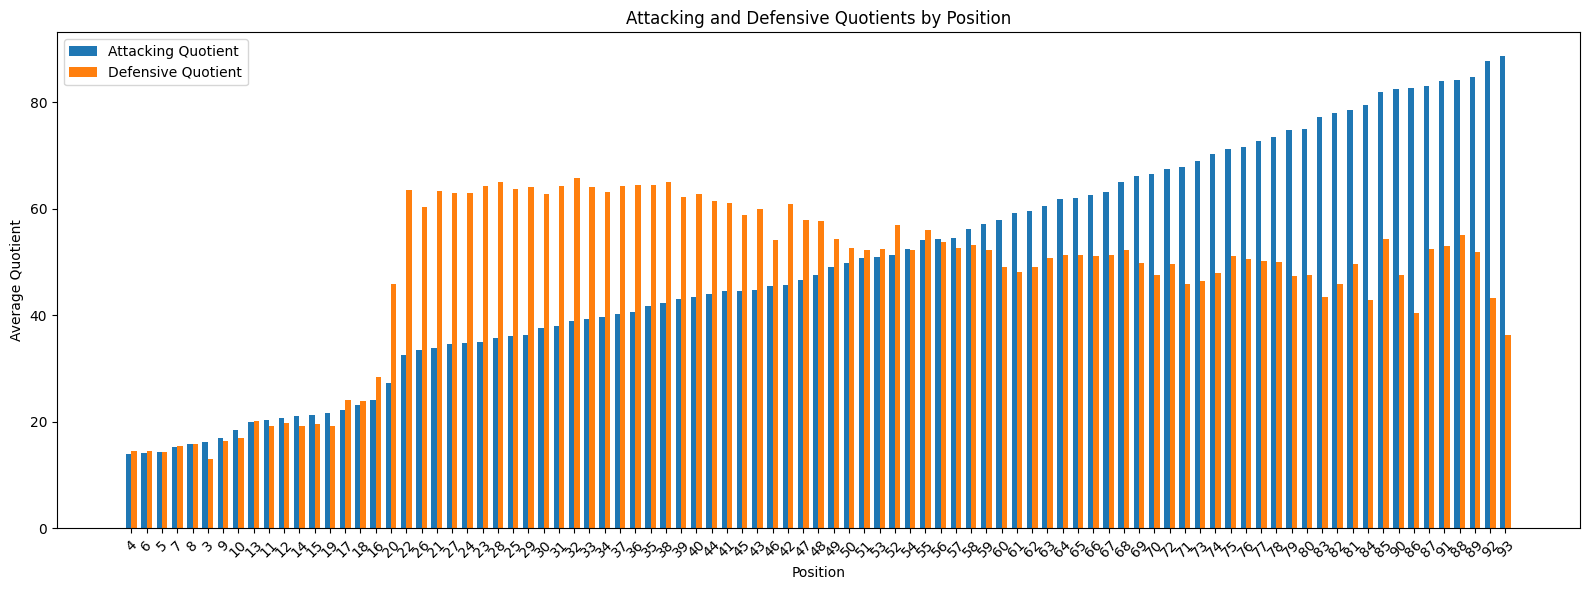

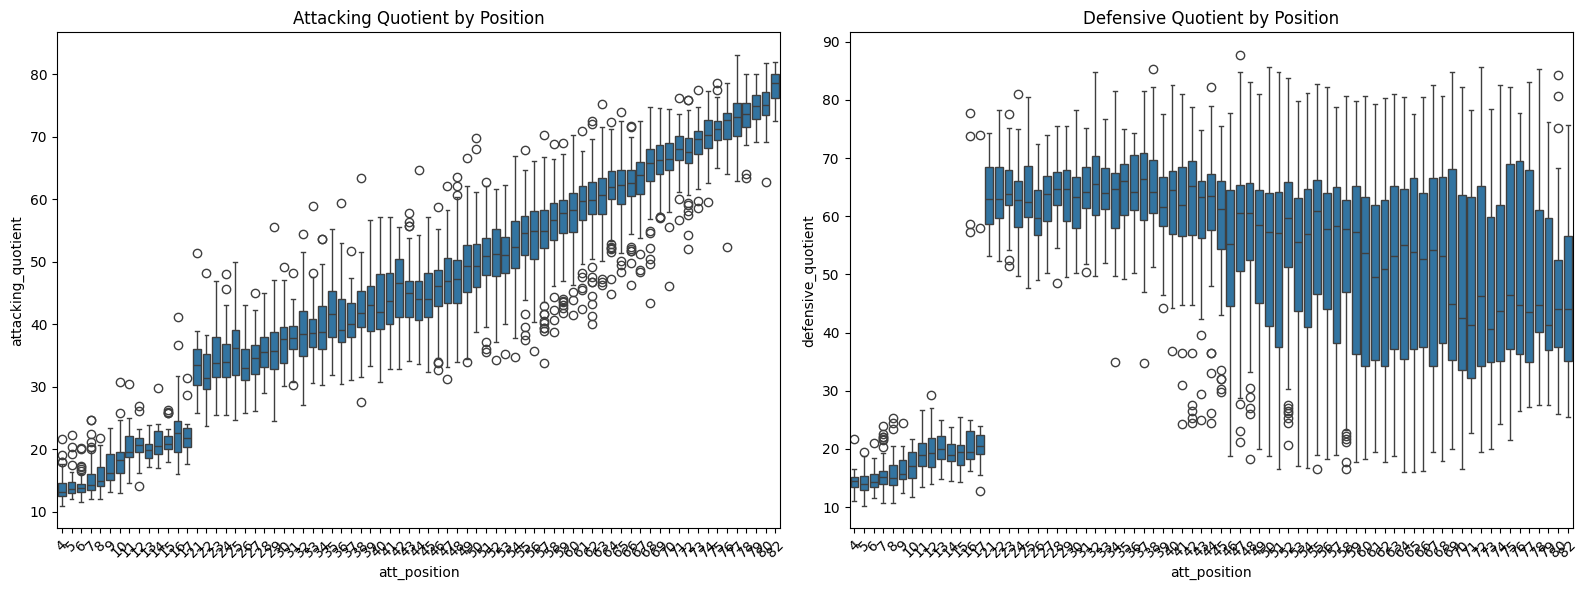

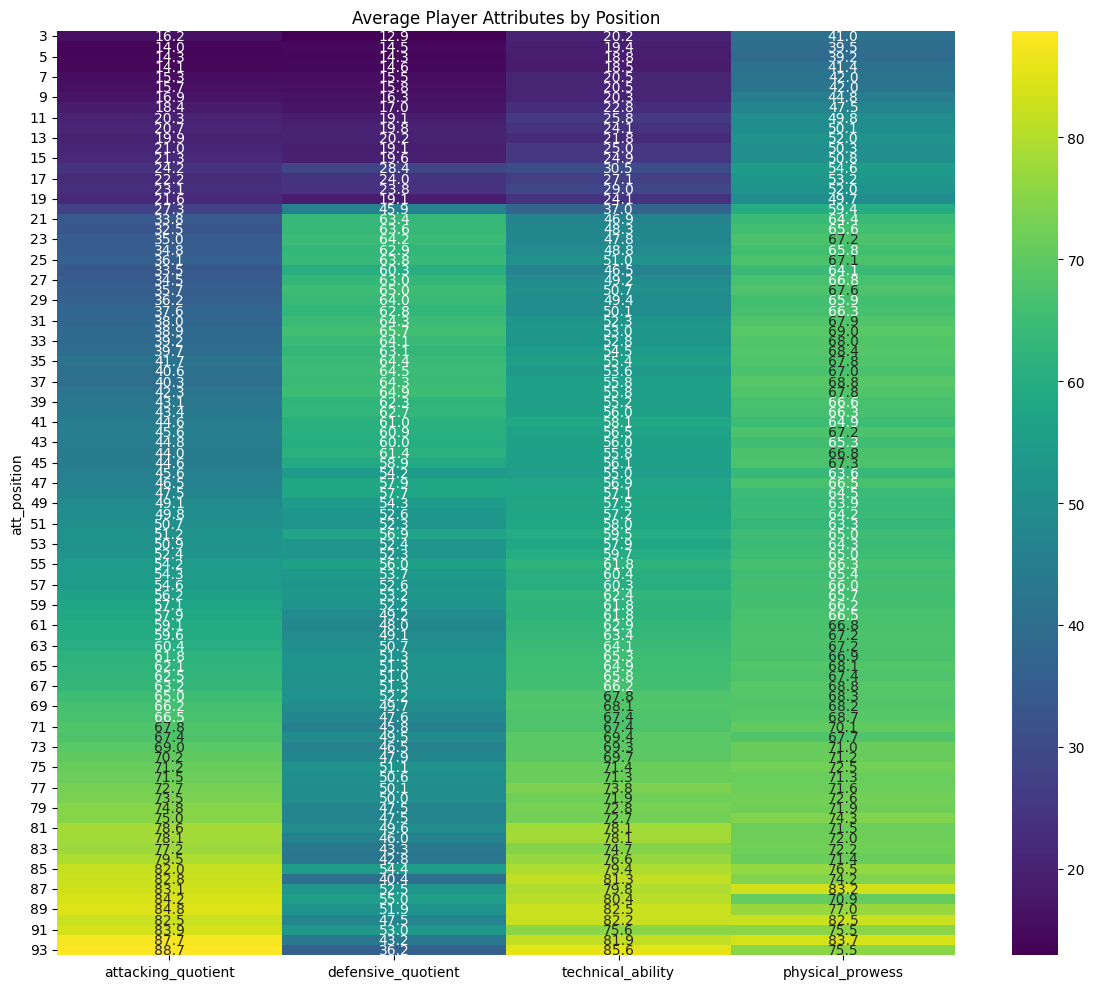

In [6]:
# Group data by position and calculate mean values
position_stats = df.groupby('att_position')[['attacking_quotient', 'defensive_quotient']].mean().reset_index()
position_stats = position_stats.sort_values('attacking_quotient')

# Create the bar chart with grouped data
plt.figure(figsize=(16, 6))
x = np.arange(len(position_stats))
width = 0.35

plt.bar(x - width/2, position_stats['attacking_quotient'], width, label='Attacking Quotient')
plt.bar(x + width/2, position_stats['defensive_quotient'], width, label='Defensive Quotient')

plt.xlabel('Position')
plt.ylabel('Average Quotient')
plt.title('Attacking and Defensive Quotients by Position')
plt.xticks(x, position_stats['att_position'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Boxplots for attacking and defensive quotients by position
plt.figure(figsize=(16, 6))
positions = df['att_position'].unique()

# Filter to include only positions with enough players
position_counts = df['att_position'].value_counts()
common_positions = position_counts[position_counts > 20].index.tolist()
filtered_df = df[df['att_position'].isin(common_positions)]

# Create separate boxplots for attacking and defensive quotients
plt.subplot(1, 2, 1)
sns.boxplot(x='att_position', y='attacking_quotient', data=filtered_df)
plt.title('Attacking Quotient by Position')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='att_position', y='defensive_quotient', data=filtered_df)
plt.title('Defensive Quotient by Position')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Heatmap of average attributes by position
position_metrics = df.groupby('att_position')[['attacking_quotient', 'defensive_quotient', 'technical_ability', 'physical_prowess']].mean()

plt.figure(figsize=(12, 10))
sns.heatmap(position_metrics, annot=True, cmap='viridis', fmt='.1f')
plt.title('Average Player Attributes by Position')
plt.tight_layout()
plt.show()



--- Model Evaluation Without Tuning ---
Logistic Regression Performance:
accuracy: 0.7544
precision: 0.4780
recall: 0.8395
f1_score: 0.6092
roc_auc: 0.7844
confusion_matrix:
[[800 297]
 [ 52 272]]

Random Forest Performance:
accuracy: 0.9148
precision: 0.7977
recall: 0.8395
f1_score: 0.8180
roc_auc: 0.8883
confusion_matrix:
[[1028   69]
 [  52  272]]

XGBoost Performance:
accuracy: 0.9212
precision: 0.8081
recall: 0.8580
f1_score: 0.8323
roc_auc: 0.8989
confusion_matrix:
[[1031   66]
 [  46  278]]


--- Model Comparison (Without Tuning) ---
           Logistic Regression  Random Forest   XGBoost
Accuracy              0.754398       0.914849  0.921182
Precision             0.478032       0.797654  0.808140
Recall                0.839506       0.839506  0.858025
F1 Score              0.609183       0.818045  0.832335
ROC AUC               0.784384       0.888304  0.898930


<Figure size 1200x600 with 0 Axes>

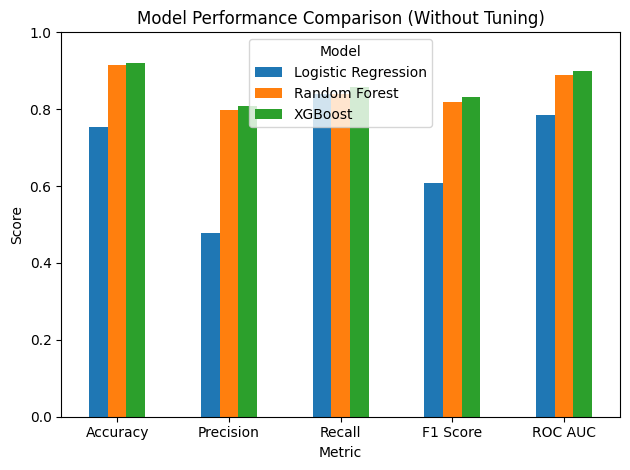

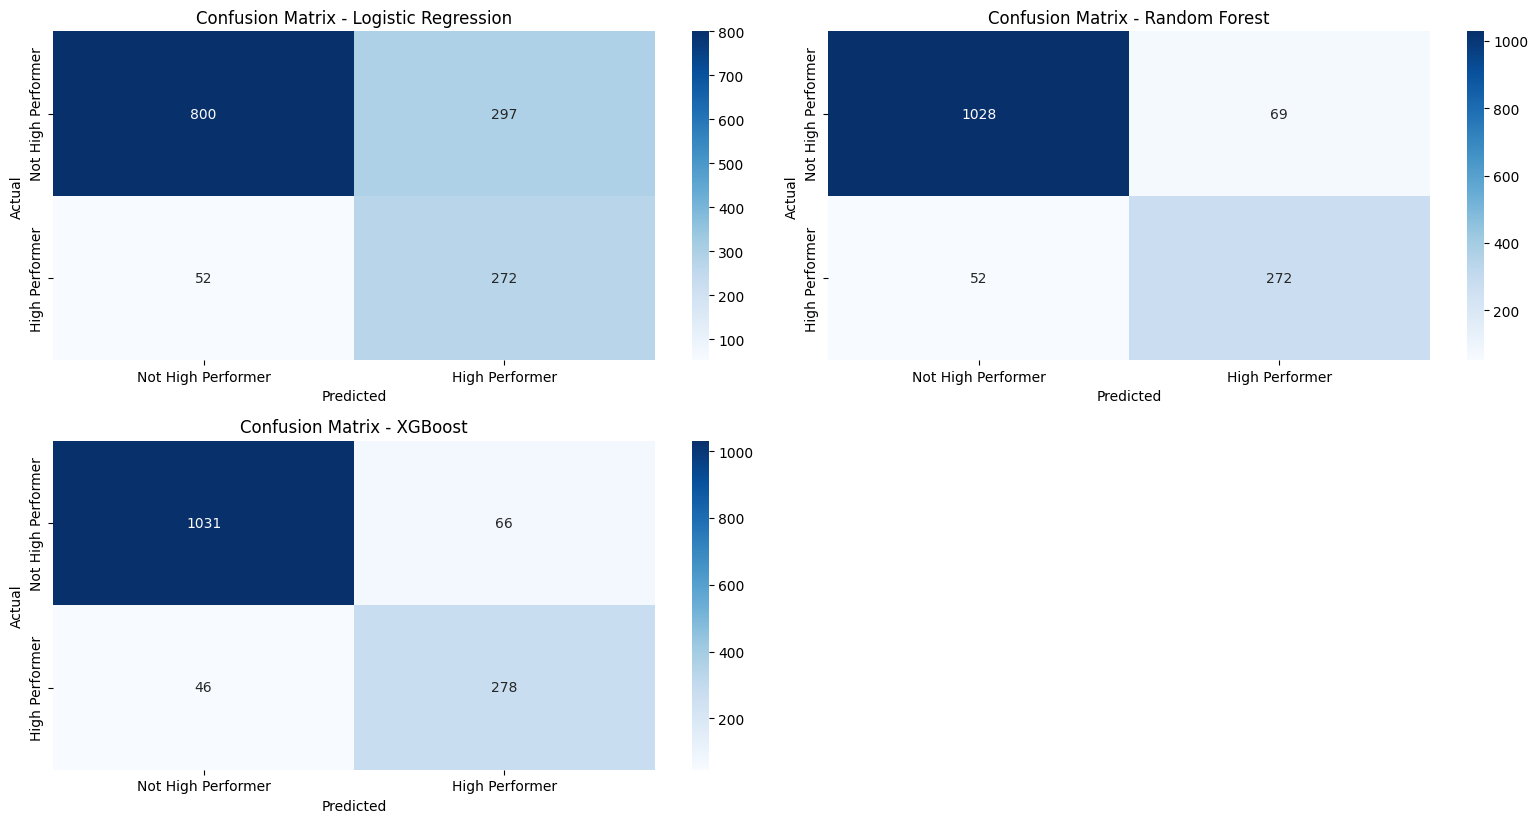

Logistic Regression: Prediction = Not High Performer (Probability: 0.4785)
Random Forest: Prediction = Not High Performer (Probability: 0.0000)
XGBoost: Prediction = Not High Performer (Probability: 0.0008)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [7]:
# Define target variable
value_threshold = df['value'].quantile(0.75)
df['high_performer'] = df['value'] > value_threshold

# Select features
features = ['attacking_quotient', 'defensive_quotient', 'technical_ability', 'physical_prowess', 'age', 'height', 'weight', 'experience_factor', 'in_prime_years', 'is_goalkeeper']
X = df[features]
y = df['high_performer']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Feature selection using SelectKBest
selector = SelectKBest(mutual_info_classif, k=8)
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
X_test_selected = selector.transform(X_test_scaled)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Evaluate models without tuning
print("\n--- Model Evaluation Without Tuning ---")
results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train_res)
    y_pred = model.predict(X_test_selected)

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    print(f"{name} Performance:")
    for metric, value in results[name].items():
        if metric == 'confusion_matrix':
            print(f"{metric}:\n{value}")
        else:
            print(f"{metric}: {value:.4f}")
    print()

# Create a DataFrame for comparison
metrics_df = pd.DataFrame({
    model: [results[model][metric] for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
    for model in results.keys()
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

print("\n--- Model Comparison (Without Tuning) ---")
print(metrics_df)

# Visualize results without tuning
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar')
plt.title('Model Performance Comparison (Without Tuning)')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


# Confusion matrix heatmap
plt.figure(figsize=(16, 12))
for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(3, 2, i)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
               xticklabels=['Not High Performer', 'High Performer'],
               yticklabels=['Not High Performer', 'High Performer'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()


# Load a sample player to demonstrate prediction
sample_player = X_test.iloc[0].values.reshape(1, -1)
# sample_player_selected = selector.transform(sample_player) # Apply feature selection to the sample player data
# sample_player_scaled = scaler.transform(sample_player_selected)  # Scale the selected features
sample_player_scaled = scaler.transform(sample_player) #Scale the original features of the sample player


for name, model in models.items():
    #prediction = model.predict(sample_player_scaled)[0] #Predict using the scaled original features
    #probability = model.predict_proba(sample_player_scaled)[0][1] # Predict probability using the scaled original features

    sample_player_selected = selector.transform(sample_player_scaled) # Apply feature selection to the scaled sample player data
    prediction = model.predict(sample_player_selected)[0] # Predict using the scaled and selected features
    probability = model.predict_proba(sample_player_selected)[0][1] # Predict probability using scaled and selected features

    print(f"{name}: Prediction = {'High Performer' if prediction == 1 else 'Not High Performer'} (Probability: {probability:.4f})")


--- Hyperparameter Tuning Results ---

Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 score: 0.8016
accuracy: 0.7544
precision: 0.4780
recall: 0.8364
f1_score: 0.6083
roc_auc: 0.7833

Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 score: 0.9538
accuracy: 0.9148
precision: 0.7977
recall: 0.8395
f1_score: 0.8180
roc_auc: 0.8883

Tuning XGBoost...
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Best F1 score: 0.9552
accuracy: 0.9191
precision: 0.8083
recall: 0.8457
f1_score: 0.8265
roc_auc: 0.8932

--- Model Comparison (After Tuning) ---
           Logistic Regression  Random Forest   XGBoost
Accuracy              0.754398       0.914849  0.919071
Precision             0.477954       0.797654  0.808260
Recall                0.836420       0.839

<Figure size 1200x600 with 0 Axes>

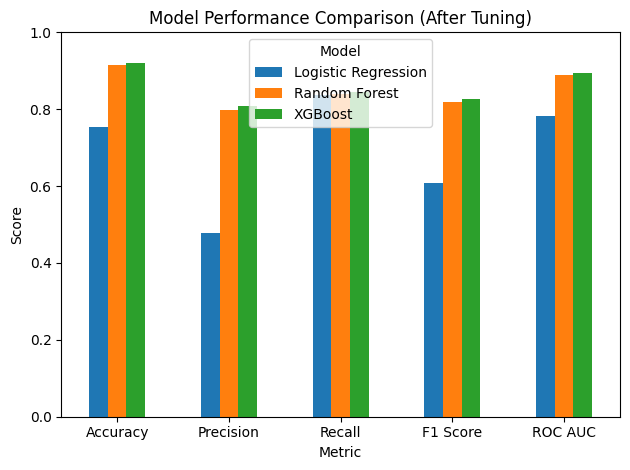

In [8]:
# Hyperparameter tuning for all models
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Perform grid search for each model
best_models = {}
tuned_results = {}

print("\n--- Hyperparameter Tuning Results ---")
for name, model in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='f1',
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train_selected, y_train_res)

    # Save the best model
    best_models[name] = grid_search.best_estimator_

    # Evaluate the best model
    y_pred_tuned = grid_search.best_estimator_.predict(X_test_selected)

    tuned_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred_tuned),
        'precision': precision_score(y_test, y_pred_tuned),
        'recall': recall_score(y_test, y_pred_tuned),
        'f1_score': f1_score(y_test, y_pred_tuned),
        'roc_auc': roc_auc_score(y_test, y_pred_tuned)
    }

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_:.4f}")
    for metric, value in tuned_results[name].items():
        print(f"{metric}: {value:.4f}")

# Create a DataFrame for tuned comparison
tuned_metrics_df = pd.DataFrame({
    model: [tuned_results[model][metric] for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
    for model in tuned_results.keys()
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

print("\n--- Model Comparison (After Tuning) ---")
print(tuned_metrics_df)

# Visualize tuned results
plt.figure(figsize=(12, 6))
tuned_metrics_df.plot(kind='bar')
plt.title('Model Performance Comparison (After Tuning)')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


--- Position-Specific Analysis with Tuning ---

Analyzing position: 60
Logistic Regression - Accuracy: 0.8906, F1: 0.5882
Random Forest - Accuracy: 0.9062, F1: 0.4000
XGBoost - Accuracy: 0.9219, F1: 0.7059

Analyzing position: 58
Logistic Regression - Accuracy: 0.8475, F1: 0.3077
Random Forest - Accuracy: 0.9153, F1: 0.4444
XGBoost - Accuracy: 0.8814, F1: 0.3636

Analyzing position: 64
Logistic Regression - Accuracy: 0.9074, F1: 0.8000
Random Forest - Accuracy: 0.9259, F1: 0.8182
XGBoost - Accuracy: 0.8704, F1: 0.6957

Analyzing position: 65
Logistic Regression - Accuracy: 0.9057, F1: 0.8000
Random Forest - Accuracy: 0.9245, F1: 0.8462
XGBoost - Accuracy: 0.9245, F1: 0.8462

Analyzing position: 57
Logistic Regression - Accuracy: 0.9423, F1: 0.4000
Random Forest - Accuracy: 0.9615, F1: 0.0000
XGBoost - Accuracy: 0.9423, F1: 0.0000


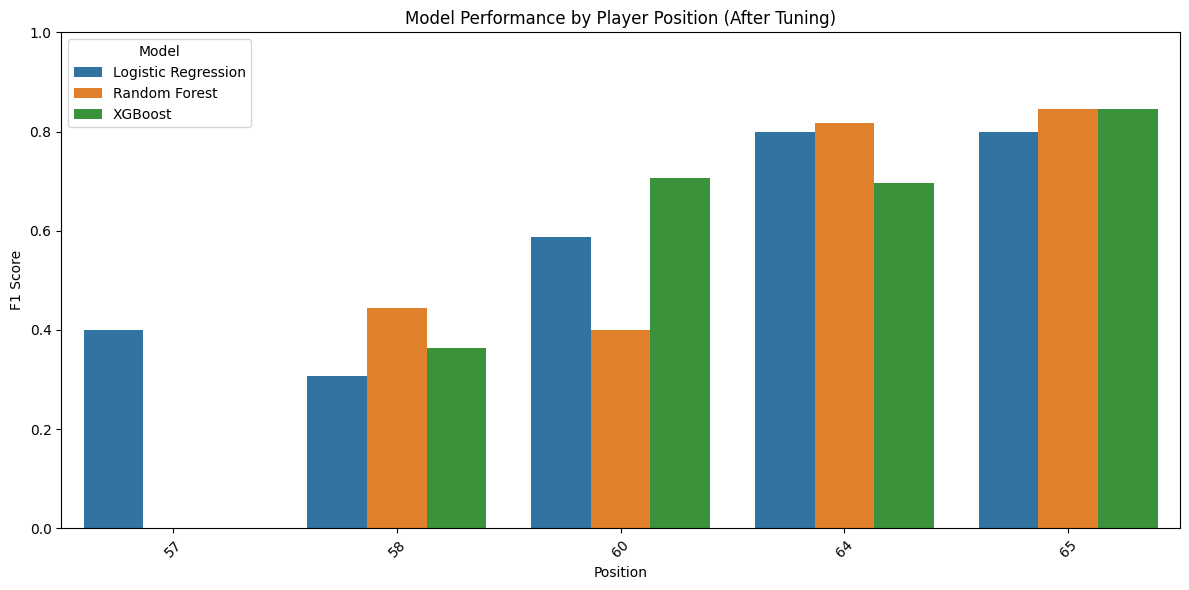


--- Best Model by Position (After Tuning) ---
60: XGBoost (F1: 0.7059)
58: Random Forest (F1: 0.4444)
64: Random Forest (F1: 0.8182)
65: Random Forest (F1: 0.8462)
57: Logistic Regression (F1: 0.4000)

--- Model Performance Summary (After Tuning) ---
XGBoost performs best on 1 positions
Random Forest performs best on 3 positions
Logistic Regression performs best on 1 positions


In [9]:
# Position-specific analysis with hyperparameter tuning for XGBoost
print("\n--- Position-Specific Analysis with Tuning ---")
# Filter for only positions with sufficient data
min_players = 100  # Set minimum number of players per position
position_counts = df['att_position'].value_counts()
valid_positions = position_counts[position_counts >= min_players].index.tolist()

# Dictionary to store position-specific results
position_results = {position: {} for position in valid_positions[:5]}  # Limit to top 5 positions

# Hyperparameter grid for XGBoost (position-specific)
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

for position in valid_positions[:5]:  # Limit to top 5 positions
    # Filter data for this position
    print(f"\nAnalyzing position: {position}")
    position_data = df[df['att_position'] == position]

    # Define features and target for this position
    X_pos = position_data[features]
    y_pos = position_data['high_performer']

    # Split and scale
    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
        X_pos, y_pos, test_size=0.3, random_state=42)

    X_train_pos_scaled = scaler.fit_transform(X_train_pos)
    X_test_pos_scaled = scaler.transform(X_test_pos)

    # Address class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_res_pos, y_train_res_pos = smote.fit_resample(X_train_pos_scaled, y_train_pos)

    # Train and evaluate each model
    for name, model_class in [
        ('Logistic Regression', LogisticRegression),
        ('Random Forest', RandomForestClassifier),
        ('XGBoost', xgb.XGBClassifier)
    ]:
        # Create and train model
        if name == 'Logistic Regression':
            model = model_class(random_state=42, max_iter=1000)
        elif name == 'XGBoost':
            # Perform hyperparameter tuning for XGBoost
            grid_search = GridSearchCV(
                estimator=model_class(random_state=42),
                param_grid=xgb_param_grid,
                scoring='f1',
                cv=5,
                n_jobs=-1
            )
            grid_search.fit(X_train_res_pos, y_train_res_pos)
            model = grid_search.best_estimator_
        else:
            model = model_class(random_state=42)

        model.fit(X_train_res_pos, y_train_res_pos)

        # Evaluate
        y_pred_pos = model.predict(X_test_pos_scaled)

        position_results[position][name] = {
            'accuracy': accuracy_score(y_test_pos, y_pred_pos),
            'f1_score': f1_score(y_test_pos, y_pred_pos)
        }

        print(f"{name} - Accuracy: {position_results[position][name]['accuracy']:.4f}, "
              f"F1: {position_results[position][name]['f1_score']:.4f}")

# Create DataFrame for position-specific results
position_df_data = []
for position in position_results:
    for model in position_results[position]:
        position_df_data.append({
            'Position': position,
            'Model': model,
            'Accuracy': position_results[position][model]['accuracy'],
            'F1 Score': position_results[position][model]['f1_score']
        })

position_df = pd.DataFrame(position_df_data)

# Plot position-specific results
plt.figure(figsize=(12, 6))
sns.barplot(x='Position', y='F1 Score', hue='Model', data=position_df)
plt.title('Model Performance by Player Position (After Tuning)')
plt.xlabel('Position')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Find which model performs best for each position
best_models_by_position = {}
for position in position_results:
    f1_scores = {model: position_results[position][model]['f1_score']
                for model in position_results[position]}
    best_model = max(f1_scores, key=f1_scores.get)
    best_models_by_position[position] = {
        'best_model': best_model,
        'f1_score': f1_scores[best_model]
    }

print("\n--- Best Model by Position (After Tuning) ---")
for position, result in best_models_by_position.items():
    print(f"{position}: {result['best_model']} (F1: {result['f1_score']:.4f})")

# Count how many positions each model performs best on
model_position_counts = {}
for position, result in best_models_by_position.items():
    model = result['best_model']
    if model not in model_position_counts:
        model_position_counts[model] = 0
    model_position_counts[model] += 1

print("\n--- Model Performance Summary (After Tuning) ---")
for model, count in model_position_counts.items():
    print(f"{model} performs best on {count} positions")

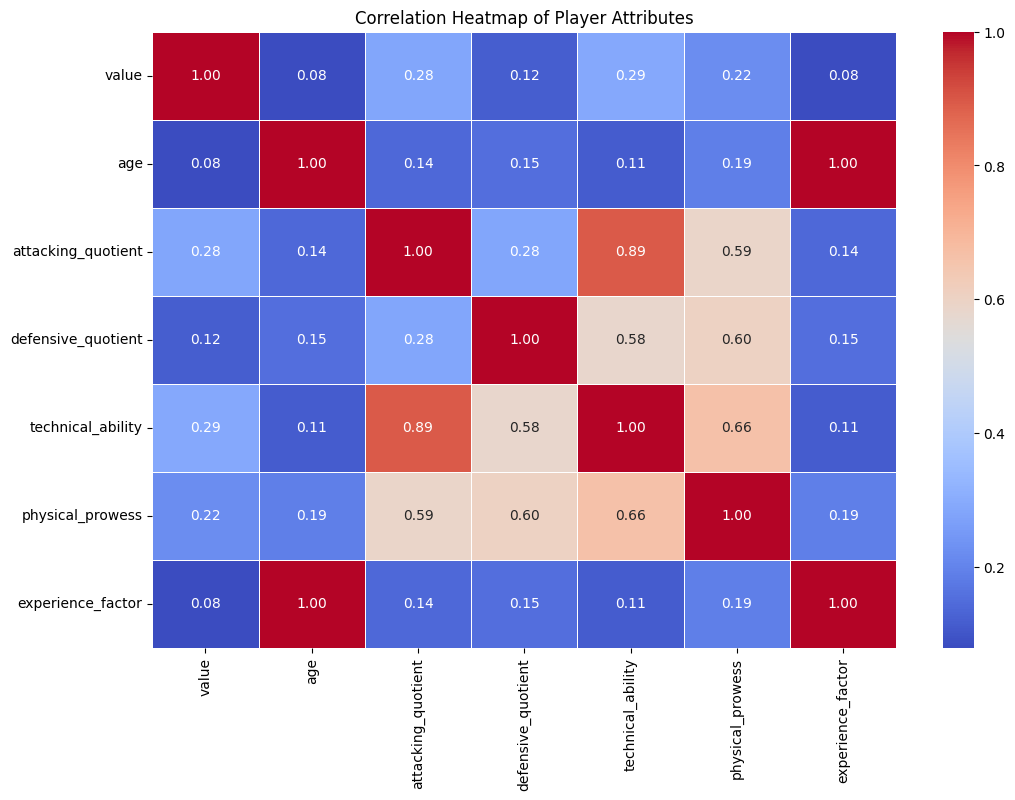

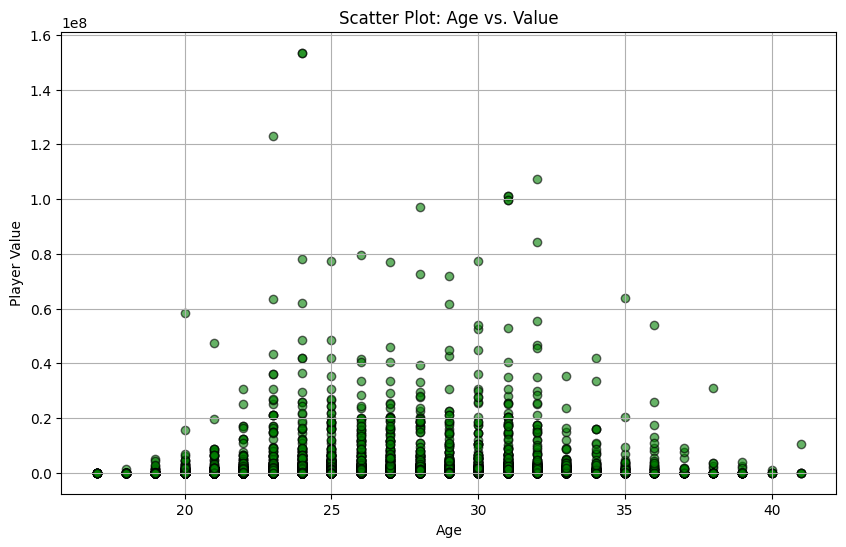

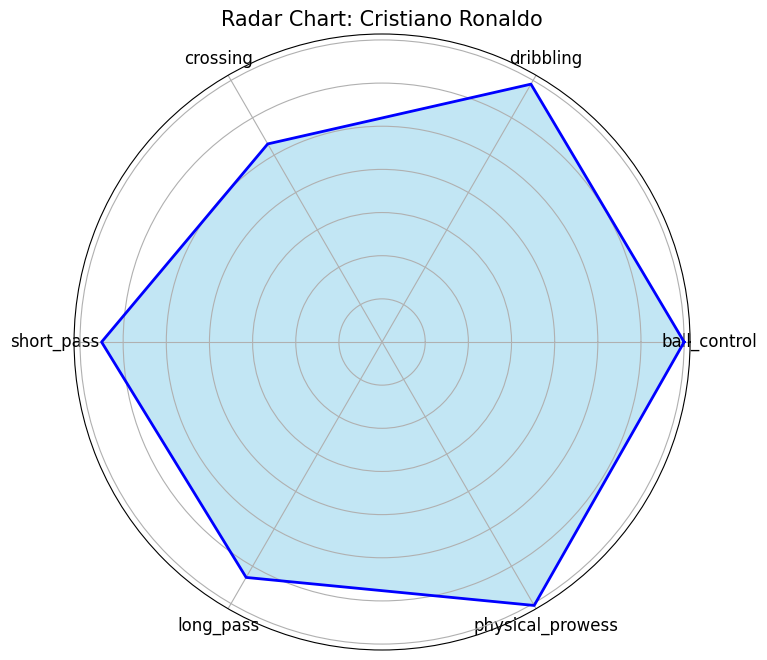

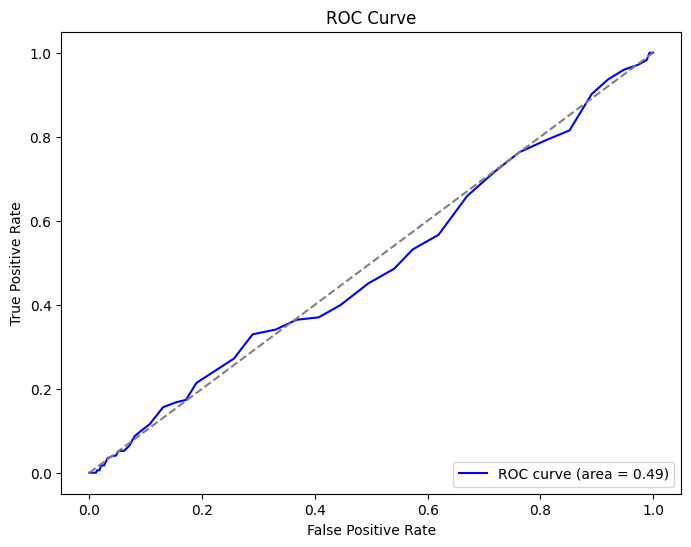

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Select relevant columns for correlation
correlation_cols = ['value', 'age', 'attacking_quotient', 'defensive_quotient', 'technical_ability', 'physical_prowess', 'experience_factor']
correlation_matrix = df[correlation_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Player Attributes')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['value'], alpha=0.6, color='green', edgecolors='black')
plt.title('Scatter Plot: Age vs. Value')
plt.xlabel('Age')
plt.ylabel('Player Value')
plt.grid(True)
plt.show()

# Select a sample player
player_index = 100
player = df.iloc[player_index]

# Metrics to plot
metrics = ['ball_control', 'dribbling', 'crossing', 'short_pass', 'long_pass', 'physical_prowess']
values = player[metrics].tolist()

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
values += values[:1]  # Repeat first value at the end to close the circle
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='skyblue', alpha=0.5)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)

# Set a custom player name
plt.title('Radar Chart: Cristiano Ronaldo', fontsize=15)
plt.show()

# Simulated dataset based on the given columns
np.random.seed(42)
n = 5682

# Features relevant to goalkeepers
X = np.random.randint(0, 100, size=(n, 5))
y = np.random.choice([0, 1], size=n, p=[0.85, 0.15])  # 15% goalkeepers, 85% field players

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
